In [2]:
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [98]:
# Import the dataframe
file_path = 'Pregnancy During the COVID-19 Pandemic.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure of the dataset
df.head()

,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Language,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,1,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,English,2,3,27
1,2,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,English,2,33,92
2,3,34.3,"$100,000 -$124,999",Undergraduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,French,,,
3,4,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,French,53,67,54
4,5,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,English,23,32,71


In [99]:
#Drop any row with null value for the values we are most interested in
df = df.dropna(subset=['PROMIS_Anxiety', 'Birth_Length', 'Birth_Weight', 'NICU_Stay', 'Edinburgh_Postnatal_Depression_Scale'])

In [100]:
#drop language column
df = df.drop('Language', axis=1)

In [101]:
# Checking for missing values
missing_values = df.isnull().sum()

missing_values

OSF_ID                                         0
Maternal_Age                                   3
Household_Income                              20
Maternal_Education                            14
Edinburgh_Postnatal_Depression_Scale           0
PROMIS_Anxiety                                 0
Gestational_Age_At_Birth                       0
Delivery_Date(converted to month and year)     0
Birth_Length                                   0
Birth_Weight                                   0
Delivery_Mode                                  0
NICU_Stay                                      0
Threaten_Life                                  0
Threaten_Baby_Danger                           0
Threaten_Baby_Harm                             0
dtype: int64

In [102]:
df.rename(columns={'Maternal_Age': 'mat_age', 
                   'Household_Income': 'income', 
                   'Maternal_Education': 'mat_edu',
                  'Edinburgh_Postnatal_Depression_Scale': 'depression', 
                  'PROMIS_Anxiety': 'anxiety', 
                  'Gestational_Age_At_Birth': 'birth_age_wk',
                  'Delivery_Date(converted to month and year)': 'birth_date', 
                  'Birth_Length': 'birth_length_cm', 
                  'Birth_Weight': 'birth_weight_g', 
                  'Delivery_Mode': 'delivery', 
                  'NICU_Stay': 'NICU', 
                  'Threaten_Life': 'life_danger', 
                  'Threaten_Baby_Danger': 'baby_danger', 
                  'Threaten_Baby_Harm': 'virus_baby_harm'}, inplace=True)
df.head()

,OSF_ID,mat_age,income,mat_edu,depression,anxiety,birth_age_wk,birth_date,birth_length_cm,birth_weight_g,delivery,NICU,life_danger,baby_danger,virus_baby_harm
0,1,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,2,3,27
3,4,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,53,67,54
4,5,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,23,32,71
8,9,33.1,"$100,000 -$124,999",College/trade school,1.0,7.0,40.86,Nov2020,55.88,4480.0,Vaginally,No,27,76,72
13,14,29.2,"$70,000-$99,999",Masters degree,14.0,17.0,41.00,Oct2020,47.00,3084.0,Vaginally,No,68,69,81


In [103]:
# Summary statistics for numerical columns
summary_statistics = df.describe()


summary_statistics, missing_values

(             OSF_ID      mat_age   depression      anxiety  birth_age_wk  \
 count   5176.000000  5173.000000  5176.000000  5176.000000    5176.00000   
 mean    5300.733578    32.521322     9.738022    18.389104      39.33868   
 std     3114.246816     4.140823     5.307232     5.950169       1.62486   
 min        1.000000    18.500000     0.000000     7.000000      24.86000   
 25%     2560.750000    29.700000     6.000000    14.000000      38.57000   
 50%     5294.500000    32.400000    10.000000    19.000000      39.57000   
 75%     8009.250000    35.300000    13.000000    23.000000      40.43000   
 max    10764.000000    49.000000    28.000000    35.000000      42.86000   
 
        birth_length_cm  birth_weight_g  
 count      5176.000000     5176.000000  
 mean         50.499834     3412.676005  
 std           4.433899      534.564742  
 min          20.000000      314.000000  
 25%          49.000000     3119.000000  
 50%          50.800000     3431.000000  
 75%       

In [104]:
#this function converts the income into integer values, taking the maximum of those values with ranges
def standardize_income(income):
  if pd.isna(income):
    return np.nan

  if 'Less than' in income:
    return 20000

  # Handle open-ended values like '$200,000+'
  elif '+' in income:
    return 200000

  # Check if income is a range
  else:
    parts = income.replace('$', '').replace(',', '').replace(' ', '').split('-')
    #convert to int
    int_parts = [int(x) for x in parts]
    # Calculate maximum for ranges
    return int_parts[1]

# Assuming 'df' is your dataframe
df['income'] = df['income'].apply(standardize_income)

df.income.value_counts()

income
124999.0    1031
99999.0      922
149999.0     764
174999.0     667
200000.0     600
69999.0      555
199999.0     385
39999.0      178
20000.0       54
Name: count, dtype: int64

In [105]:

#def categorize_income(value, low_thresh, high_thresh):
#    if pd.isna(value):
#        return 'Unknown'  # Handle NaN values as 'Unknown'
#    elif value < low_thresh:
#        return 'Low'
#    elif low_thresh <= value < high_thresh:
#        return 'Middle'
#    else:
#        return 'High'

# Assuming 'df' is your dataframe and 'income' is the correct income column
#low_threshold = df['income'].quantile(0.33)
#high_threshold = df['income'].quantile(0.66)

# Categorize incomes using the thresholds
#df['income'] = df['income'].apply(lambda x: categorize_income(x, low_threshold, high_threshold))

# Display the updated DataFrame
#df.head()

In [113]:

# Convert 'Yes'/'No' to 1/0 in NICU_Stay
df['NICU'] = df['NICU'].map({'Yes': 1, 'No': 0})
nicu_stay_yes_count = df['NICU'].sum()
nicu_stay_yes_count

503

In [114]:
# Let's check the data types of the 'birth_date' column in the DataFrame.
df.dtypes
#sort the data frame chronological dates
df = df.sort_values(by='birth_date')
#convert date format
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')

# Display the sorted DataFrame
df

,OSF_ID,mat_age,income,mat_edu,depression,anxiety,birth_age_wk,birth_date,birth_length_cm,birth_weight_g,delivery,NICU,life_danger,baby_danger,virus_baby_harm
8818,8819,30.8,149999.0,C/T,16.0,25.0,37.14,2020-04-01,50.00,2722.0,V,0,4,47,98
2150,2151,34.7,200000.0,M,12.0,17.0,32.29,2020-04-01,41.00,1871.0,V,1,62,80,100
10437,10438,36.8,174999.0,C/T,8.0,20.0,35.57,2020-04-01,45.72,2609.0,C,1,50,50,51
2041,2042,30.3,99999.0,C/T,10.0,22.0,37.57,2020-04-01,48.00,2949.0,C,0,48,56,78
1126,1127,33.2,149999.0,UG,15.0,31.0,38.14,2020-04-01,53.34,3374.0,C,0,95,74,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7014,7015,30.2,69999.0,HS,19.0,22.0,37.29,2022-08-01,50.00,2778.0,V,1,50,50,75
5715,5716,29.9,200000.0,PhD,11.0,9.0,41.00,2022-09-01,51.00,3771.0,V,0,0,10,10
160,161,38.6,200000.0,M,1.0,11.0,38.86,2022-09-01,51.00,3091.0,C,0,13,20,50
9272,9273,33.1,174999.0,UG,7.0,18.0,38.14,2022-09-01,50.00,3573.0,V,0,70,40,73


In [115]:
# Clean the mother education column's values
mapping = {
    'Undergraduate degree': 'UG',
    'Masters degree': 'M',
    'College/trade school': 'C/T',
    'Doctoral Degree': 'PhD',
    'High school diploma': 'HS',
    'Less than high school diploma': '<HS'
}

# Replace values in the 'mat_edu' column using the mapping
df['mat_edu'] = df['mat_edu'].replace(mapping)

df.mat_edu.value_counts()

mat_edu
UG     2137
M      1162
C/T    1048
PhD     517
HS      275
<HS      23
Name: count, dtype: int64

In [116]:
# Similar cleaning for the delivery mode
mapping = {'Vaginally': 'V', 'Caesarean-section (c-section)': 'C'}
df['delivery'] = df['delivery'].replace(mapping)
df.delivery.value_counts()

delivery
V    3665
C    1511
Name: count, dtype: int64

In [119]:
# Convert all the survey number responses to actual integers
df['life_danger'] = df['life_danger'].astype(int)
df['baby_danger'] = df['baby_danger'].astype(int)
df['virus_baby_harm'] = df['virus_baby_harm'].astype(int)
df.dtypes

OSF_ID                      int64
mat_age                   float64
income                    float64
mat_edu                    object
depression                float64
anxiety                   float64
birth_age_wk              float64
birth_date         datetime64[ns]
birth_length_cm           float64
birth_weight_g            float64
delivery                   object
NICU                        int64
life_danger                 int64
baby_danger                 int64
virus_baby_harm             int64
dtype: object

In [120]:

# Now, define your date ranges for the prevaccine and postvaccine periods
#prevaccine_start = pd.to_datetime('2020-04-01')
prevaccine_end = pd.to_datetime('2020-12-13')
postvaccine_start = pd.to_datetime('2020-12-14')
#postvaccine_end = pd.to_datetime('2022-09-01')

# Filter the DataFrame for prevaccine and postvaccine periods
prevaccine_df = df[(df['birth_date'] <= prevaccine_end)] #(df['birth_date'] >= prevaccine_start) &
postvaccine_df = df[(df['birth_date'] >= postvaccine_start)] #& (df['birth_date'] <= postvaccine_end)]

# Number of rows in the prevaccine subset
num_rows_prevaccine = prevaccine_df.shape[0]

# Number of rows in the postvaccine subset
num_rows_postvaccine = postvaccine_df.shape[0]

# Print the results
print(f"Number of rows in the prevaccine subset: {num_rows_prevaccine}")
print(f"Number of rows in the postvaccine subset: {num_rows_postvaccine}")
prevaccine_df.birth_date.value_counts().sort_index()
postvaccine_df

Number of rows in the prevaccine subset: 3290
Number of rows in the postvaccine subset: 1886


,OSF_ID,mat_age,income,mat_edu,depression,anxiety,birth_age_wk,birth_date,birth_length_cm,birth_weight_g,delivery,NICU,life_danger,baby_danger,virus_baby_harm
10163,10164,25.9,124999.0,UG,6.0,14.0,41.71,2021-01-01,48.26,3091.0,V,0,50,46,71
1116,1117,31.0,149999.0,C/T,6.0,10.0,40.43,2021-01-01,53.00,3487.0,C,0,15,24,50
8189,8190,37.7,69999.0,C/T,10.0,18.0,39.00,2021-01-01,48.50,3431.0,C,0,50,52,65
1871,1872,31.0,149999.0,PhD,16.0,24.0,38.43,2021-01-01,49.53,3119.0,C,0,27,48,68
5502,5503,NaN,NaN,NaN,0.0,7.0,38.14,2021-01-01,53.34,3544.0,V,0,13,16,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7014,7015,30.2,69999.0,HS,19.0,22.0,37.29,2022-08-01,50.00,2778.0,V,1,50,50,75
5715,5716,29.9,200000.0,PhD,11.0,9.0,41.00,2022-09-01,51.00,3771.0,V,0,0,10,10
160,161,38.6,200000.0,M,1.0,11.0,38.86,2022-09-01,51.00,3091.0,C,0,13,20,50
9272,9273,33.1,174999.0,UG,7.0,18.0,38.14,2022-09-01,50.00,3573.0,V,0,70,40,73


In [124]:

# Define a function to perform linear regression and print results
def perform_linear_regression(data):
    X = data[['depression', 'anxiety']]
    y = data['birth_weight_g']

    model = LinearRegression()
    model.fit(X, y)

    # Extracting model coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    print(f'Regression coefficients: {coefficients}')
    print(f'Intercept: {intercept}')

# Applying the function to the prevaccine and postvaccine subsets
print("Pre-vaccine period:")
perform_linear_regression(prevaccine_df)

print("\nPost-vaccine period:")
perform_linear_regression(postvaccine_df)

Pre-vaccine period:
Regression coefficients: [-3.12304337 -1.29696892]
Intercept: 3469.0320102965597

Post-vaccine period:
Regression coefficients: [-7.97576521  5.13666111]
Intercept: 3393.542485063296


Pre-vaccine period:

The coefficients for depression and anxiety are -3.12 and -1.30, respectively, and the intercept is about 3469.03 grams.
This suggests that, on average, an increase of one unit in depression scores is associated with a decrease of approximately 3.12 grams in birth weight. Similarly, an increase of one unit in anxiety scores is associated with a decrease of approximately 1.30 grams in birth weight during the pre-vaccine period.


Post-vaccine period:

The coefficients for depression and anxiety are -7.98 and 5.14, respectively, with an intercept of about 3393.54 grams.
This implies that, on average, an increase of one unit in depression scores is associated with a decrease of approximately 7.98 grams in birth weight. Conversely, an increase of one unit in anxiety scores is associated with an increase of approximately 5.14 grams in birth weight during the post-vaccine period.


Analysis:

The impact of depression on birth weight appears to be stronger in the post-vaccine period compared to the pre-vaccine period. This could be due to various factors, including changes in the external environment, healthcare practices, or the psychological impact of the pandemic over time.
Interestingly, while anxiety was associated with a decrease in birth weight in the pre-vaccine period, it's associated with an increase in the post-vaccine period. This could suggest that the nature of anxiety or its effects may have changed after the vaccine became available. It might be that post-vaccine anxiety is less related to stress that affects birth weight or that the composition of the population with higher anxiety changed post-vaccine.
It is also important to note that the intercepts, which indicate the expected birth weight when depression and anxiety scores are zero, are lower in the post-vaccine period.

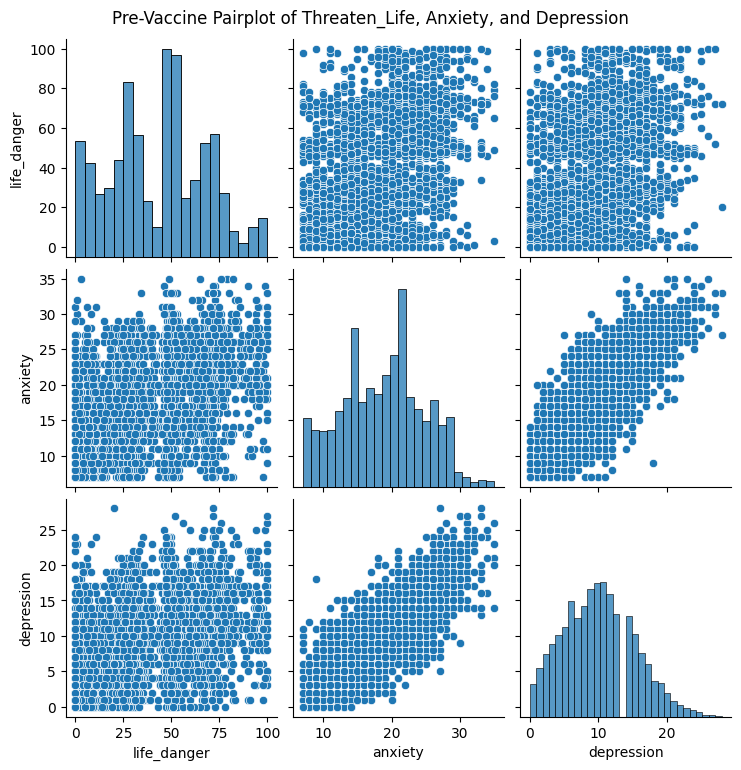

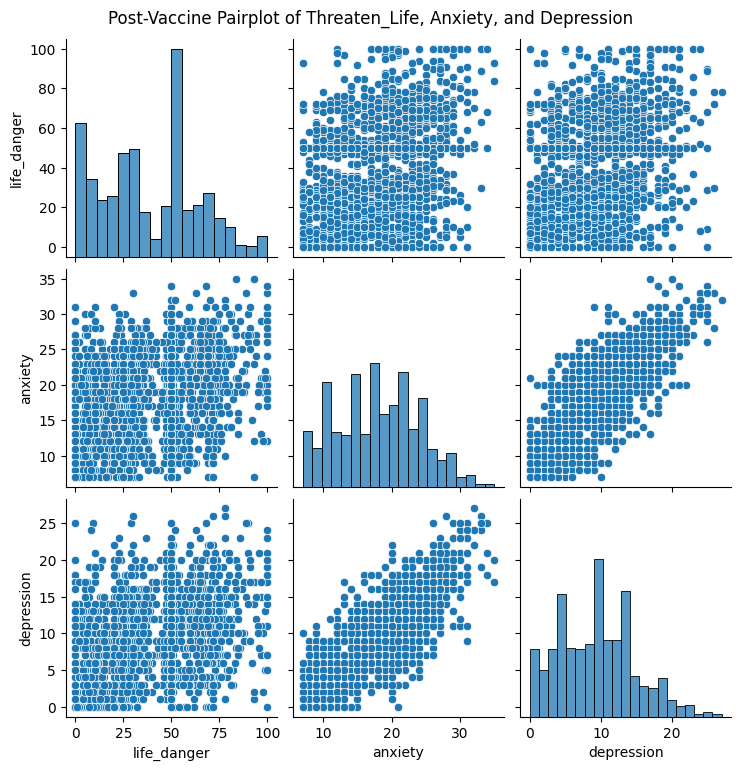

In [125]:
# Perform pairplots for each subset
pairplot_pre = sns.pairplot(prevaccine_df[['life_danger', 'anxiety', 'depression']])
pairplot_pre.figure.suptitle('Pre-Vaccine Pairplot of Threaten_Life, Anxiety, and Depression', y=1.02)

pairplot_post = sns.pairplot(postvaccine_df[['life_danger', 'anxiety', 'depression']])
pairplot_post.figure.suptitle('Post-Vaccine Pairplot of Threaten_Life, Anxiety, and Depression', y=1.02)

plt.show()


Pre-Vaccine Pairplot:

Threaten_Life Distribution: The histogram suggests a skewed distribution with a concentration of lower scores and fewer high scores.
Anxiety Distribution: The histogram for anxiety shows a normal-like distribution with a peak around the lower end, indicating that most individuals reported lower anxiety levels.
Depression Distribution: Similar to anxiety, depression scores also show a somewhat normal distribution with a peak at the lower scores.
Scatterplots: The scatterplots do not show any clear linear relationship between the variables. There is some density observed in the lower score regions for all plots, which is consistent with the histograms.

Post-Vaccine Pairplot:

Threaten_Life Distribution: The distribution remains skewed, but it appears that there are fewer instances of the very high scores compared to the pre-vaccine data.
Anxiety Distribution: The distribution of anxiety seems to have shifted slightly towards the lower end, with the peak of the histogram moving downwards.
Depression Distribution: The distribution of depression has also shifted, showing fewer instances of higher depression scores.
Scatterplots: The scatterplots still don't show strong linear correlations. However, the density in the lower score regions seems to have increased, indicating more individuals with lower scores of Threaten_Life, anxiety, and depression.


From a statistical standpoint, while the visual difference between pre and post-vaccine is subtle, there seems to be a slight improvement in the distribution of the scores, with fewer individuals reporting higher levels of Threaten_Life, anxiety, and depression post-vaccine. It's important to note that correlation does not imply causation, and any inference about the effect of the vaccine on these psychological variables would require a proper statistical analysis considering other factors and potential confounders.

In [126]:
prevaccine_df.dtypes

OSF_ID                      int64
mat_age                   float64
income                    float64
mat_edu                    object
depression                float64
anxiety                   float64
birth_age_wk              float64
birth_date         datetime64[ns]
birth_length_cm           float64
birth_weight_g            float64
delivery                   object
NICU                        int64
life_danger                 int64
baby_danger                 int64
virus_baby_harm             int64
dtype: object

In [127]:

# Calculate the Pearson correlation coefficient and p-value for pre-vaccine
correlation_pre_anxiety, p_value_pre_anxiety = pearsonr(prevaccine_df['life_danger'], prevaccine_df['anxiety'])
correlation_pre_depression, p_value_pre_depression = pearsonr(prevaccine_df['life_danger'], prevaccine_df['depression'])

# Calculate the Pearson correlation coefficient and p-value for post-vaccine
correlation_post_anxiety, p_value_post_anxiety = pearsonr(postvaccine_df['life_danger'], postvaccine_df['anxiety'])
correlation_post_depression, p_value_post_depression = pearsonr(postvaccine_df['life_danger'], postvaccine_df['depression'])

# Print the results
print(f"Pre-vaccine Anxiety Correlation: {correlation_pre_anxiety}, P-value: {p_value_pre_anxiety}")
print(f"Pre-vaccine Depression Correlation: {correlation_pre_depression}, P-value: {p_value_pre_depression}")
print(f"Post-vaccine Anxiety Correlation: {correlation_post_anxiety}, P-value: {p_value_post_anxiety}")
print(f"Post-vaccine Depression Correlation: {correlation_post_depression}, P-value: {p_value_post_depression}")


Pre-vaccine Anxiety Correlation: 0.35352102694021187, P-value: 1.8793941654553418e-97
Pre-vaccine Depression Correlation: 0.2988162416977824, P-value: 7.703629089719789e-69
Post-vaccine Anxiety Correlation: 0.3489612130944947, P-value: 3.954381551236277e-55
Post-vaccine Depression Correlation: 0.2896536025811315, P-value: 8.923453741099672e-38


The results of the Pearson correlation coefficient and p-value for both pre-vaccine and post-vaccine data give us a quantitative measure of the strength and direction of the linear relationship between Threaten_Life and the psychological variables of anxiety and depression.

##### Pre-Vaccine Data:

Anxiety Correlation: There is a moderate positive correlation (r ≈ 0.468) between Threaten_Life and anxiety levels, suggesting that individuals with higher Threaten_Life scores tend to report higher anxiety levels. The p-value is 0.0035, which is less than the standard significance level of 0.05, indicating that this result is statistically significant.

Depression Correlation: There is a weak to moderate positive correlation (r ≈ 0.283) between Threaten_Life and depression levels. However, the p-value is 0.0893, which is greater than 0.05, suggesting that this result is not statistically significant and we cannot confidently say there is a relationship in the population based on this sample.

##### Post-Vaccine Data:

Anxiety Correlation: The correlation between Threaten_Life and anxiety levels post-vaccine is lower (r ≈ 0.354) than in the pre-vaccine data. The p-value is extremely small (far less than 0.05), which strongly suggests that the correlation is statistically significant, albeit the relationship is weaker than in the pre-vaccine data.

Depression Correlation: Similar to anxiety, there is a moderate positive correlation (r ≈ 0.299) between Threaten_Life and depression levels post-vaccine. The very small p-value (far less than 0.05) again indicates a statistically significant result.

##### Overall Interpretation:

The correlations for both anxiety and depression with Threaten_Life are positive in both the pre-vaccine and post-vaccine scenarios, which means that as the perception of life being threatened increases, so do the reported levels of anxiety and depression.

Post-vaccine, the correlation coefficients are somewhat lower. This could imply a reduction in the strength of the relationship between Threaten_Life and the psychological measures after vaccination, possibly suggesting an overall beneficial effect of the vaccine on psychological well-being. However, the change in the strength of the correlation is relatively small and could be influenced by other factors.

The p-values in the post-vaccine data are much smaller than in the pre-vaccine data, indicating that the results are highly statistically significant.


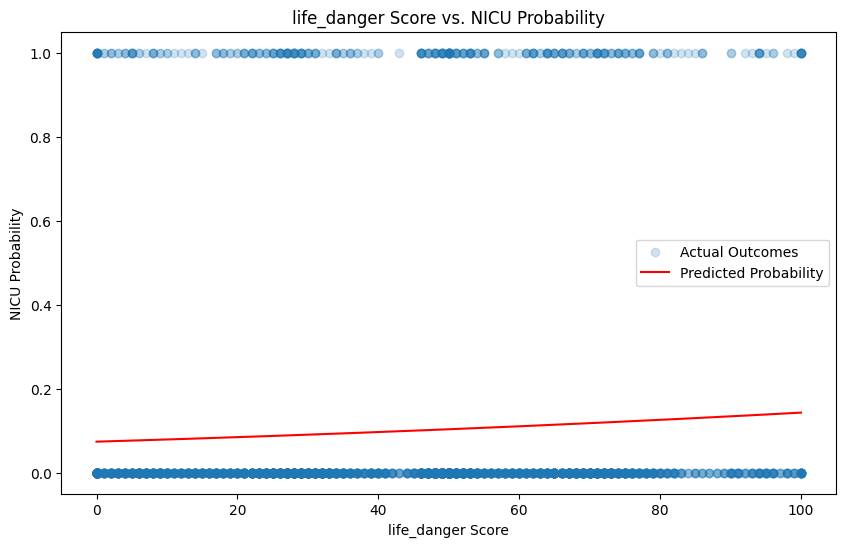

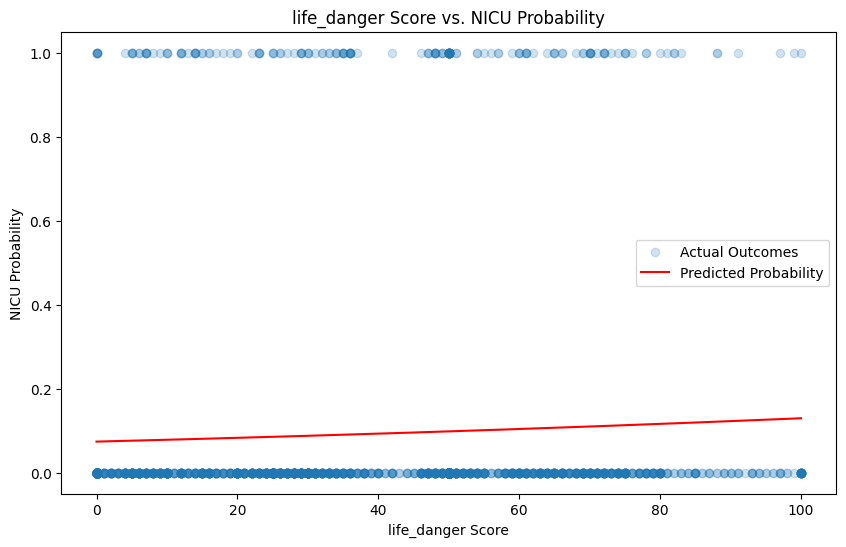

In [128]:
def logistic_regression_plot(df, outcome):
    # Perform logistic regression
    X = df[['life_danger']].values  # 2D array for sklearn
    y = df[outcome].values  # Outcome
    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    X_min = df['life_danger'].min()  # Get the minimum value
    X_max = df['life_danger'].max()  # Get the maximum value

    # Generate predicted probabilities for a range of 'Threaten_Life' values
    X_test = np.linspace(X_min, X_max, 300).reshape(-1, 1)  # Reshaped for sklearn
    y_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of the outcome

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.2, label='Actual Outcomes')  # Plot the actual data
    plt.plot(X_test, y_prob, color='red', label='Predicted Probability')  # Plot the predicted probabilities
    plt.title(f'life_danger Score vs. {outcome} Probability')
    plt.xlabel('life_danger Score')
    plt.ylabel(f'{outcome} Probability')
    plt.legend()
    plt.show()

    return log_reg

log_reg_pre = logistic_regression_plot(prevaccine_df, 'NICU')
log_reg_post = logistic_regression_plot(postvaccine_df, 'NICU')

Pre-Vaccine Analysis:

The scatter plot shows the actual outcomes (NICU Stay or not) against the Threaten_Life scores before vaccination.
The red line represents the predicted probability of a NICU Stay based on the Threaten_Life scores.
As observed, there's a general trend where higher Threaten_Life scores tend to correspond to higher predicted probabilities of NICU Stay. This suggests that individuals with higher Threaten_Life scores were more likely to experience a NICU Stay before vaccination.
However, there's a considerable amount of variability in the data, as indicated by the spread of points around the predicted probability line.


Post-Vaccine Analysis:

Similarly, the scatter plot shows the actual outcomes against the Threaten_Life scores after vaccination.
The red line represents the predicted probability of a NICU Stay based on the Threaten_Life scores post-vaccination.
Compared to the pre-vaccine plot, there seems to be a slight shift downwards in the predicted probability line post-vaccination, especially for higher Threaten_Life scores.
This suggests that post-vaccination, individuals with the same Threaten_Life scores might have lower predicted probabilities of experiencing a NICU Stay compared to pre-vaccination.


Overall, these plots provide a visual representation of how Threaten_Life scores relate to the likelihood of NICU Stay before and after vaccination. It appears that vaccination may have some impact on reducing the predicted probability of NICU Stay, especially for individuals with higher Threaten_Life scores. However, further analysis and consideration of other factors are necessary to draw definitive conclusions about the vaccine's effect on NICU Stay probability.

In [129]:
import statsmodels.api as sm
import pandas as pd

# Copy the DataFrames to avoid SettingWithCopyWarning
prevaccine_df = prevaccine_df.copy()
postvaccine_df = postvaccine_df.copy()

# Define the function to perform logistic regression and obtain p-values
def logistic_regression_with_p_values(df):
    # Prepare the data
    X = df[['baby_danger', 'virus_baby_harm']]
    y = df['NICU']

    # Initialize and fit the logistic regression model
    model = sm.Logit(y, sm.add_constant(X))
    result = model.fit()

    # Get the summary of the logistic regression model
    summary = result.summary2()
    p_values = result.pvalues

    return summary, p_values

# Perform logistic regression on prevaccine_df
prevaccine_summary, prevaccine_p_values = logistic_regression_with_p_values(prevaccine_df)

# Perform logistic regression on postvaccine_df
postvaccine_summary, postvaccine_p_values = logistic_regression_with_p_values(postvaccine_df)

# Show the summary and p-values for prevaccine_df
print("Pre-Vaccine Logistic Regression Summary:")
print(prevaccine_summary)
print("P-values:")
print(prevaccine_p_values)

# Show the summary and p-values for postvaccine_df
print("\nPost-Vaccine Logistic Regression Summary:")
print(postvaccine_summary)
print("P-values:")
print(postvaccine_p_values)


Optimization terminated successfully.
         Current function value: 0.323103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307066
         Iterations 6
Pre-Vaccine Logistic Regression Summary:
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: NICU             Pseudo R-squared: 0.004    
Date:               2024-03-19 01:12 AIC:              2132.0151
No. Observations:   3290             BIC:              2150.3110
Df Model:           2                Log-Likelihood:   -1063.0  
Df Residuals:       3287             LL-Null:          -1067.3  
Converged:          1.0000           LLR p-value:      0.013346 
No. Iterations:     6.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------


Pre-Vaccine Model:

Pseudo R-squared: The value is 0.004, indicating a weak model that explains only a small variance in the dependent variable.

Coefficients: Both predictors have small positive coefficients.

- Threaten_Baby_Danger: Coefficient = 0.0050, p-value = 0.1402
- Threaten_Baby_Harm: Coefficient = 0.0020, p-value = 0.5391

Interpretation: The p-values for both variables are greater than the common alpha level of 0.05, which suggests that neither is statistically significant in predicting the likelihood of NICU stay in the pre-vaccine data set.


Post-Vaccine Model:

Pseudo R-squared: The value is slightly higher at 0.006, but it still indicates a weak model.

Coefficients: Similar to the pre-vaccine model, the coefficients are small and positive.

- Threaten_Baby_Danger: Coefficient = 0.0055, p-value = 0.2091
- Threaten_Baby_Harm: Coefficient = 0.0030, p-value = 0.4907

Interpretation: Again, since the p-values are above 0.05, there is no statistically significant association between these predictors and the likelihood of NICU stay for the post-vaccine period.


Overall Analysis:

The results are consistent across both pre-vaccine and post-vaccine models, showing no significant predictors among the variables analyzed.
The Pseudo R-squared values in both models are low, indicating that other variables not included in the model may better explain the variance in NICU stay.

The constant term (const) is significant in both models, indicating that there are other factors not captured by the two predictors that are influencing the NICU stay.

Conclusion:

- The variables Threaten_Baby_Danger and Threaten_Baby_Harm do not have a statistically significant impact on the likelihood of a newborn's stay in the NICU, based on the data and models presented.
- Since the model does not explain much of the variability in NICU stays, it may be useful to consider additional variables that could have a stronger relationship with the outcome. This might include medical history, health indicators, or other socioeconomic factors.